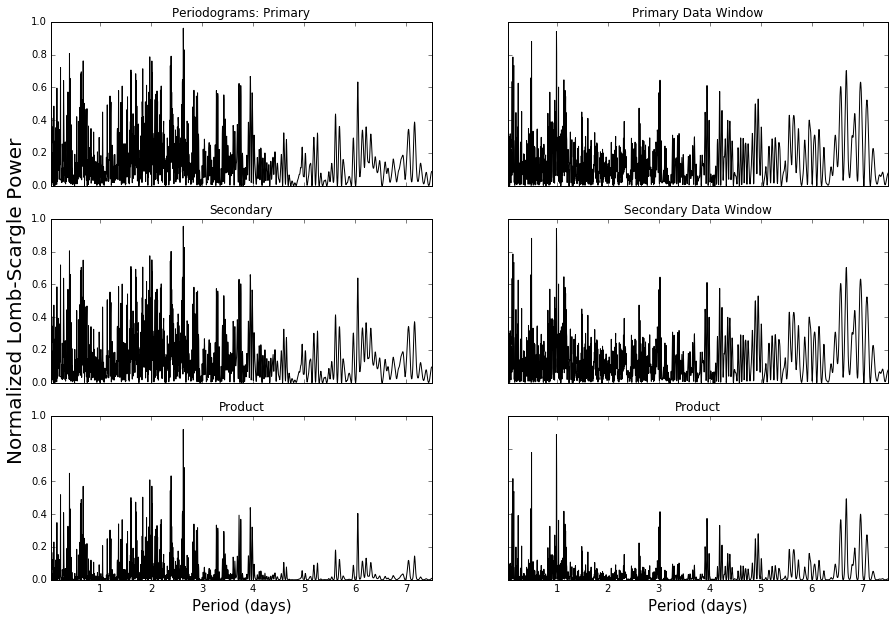

In [122]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
%matplotlib inline

DQTau1 = np.array([34.76, -2.93, 37.11, 37.38, 34.73, 31.64, 26.07, 23.51, 20.10, 17.31, 27.28, 36.99, 33.17,
                   35.11, 35.24, 28.81, 12.43, 40.09, 35.14, 35.89, 19.12, 37.08, 36.83, 12.75, -6.27, 14.82,
                   34.84,  3.16, 32.37, 39.09, 17.46, 22.67, 31.34])
DQTau2 = np.array([12.44, 56.13, 13.90, 15.01, 17.06, 20.70, 24.40, 27.30, 25.73, 27.86, 23.67, 7.64, 10.94,
                   09.87, 10.05, 19.93, 33.26, 13.83, 11.47, 16.98, 26.86, 10.20, 14.36, 23.86, 50.94, 37.61,
                   07.51, 52.75, 17.20, 08.27, 34.61, 26.25, 11.49])
HJD    = np.array([45982.0293, 46389.8446, 46745.8122, 47073.9364, 47075.9910, 47078.0084, 47127.8232, 47128.8081,
                   47159.6132, 47159.6318, 47427.9265, 47546.6122, 47546.6272, 47546.6272, 47546.6423, 47789.9412,
                   47840.8048, 47845.8709, 47896.7312, 47898.7686, 47902.6961, 48525.9580, 48670.6445, 48871.9572,
                   49344.8584, 49373.6908, 49410.6311, 49644.8270, 49699.8045, 53693.8806, 56578.9704, 56606.9106,
                   56650.8257])

#import and organize data
system = np.genfromtxt('3325505.tbl', skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs =[datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs = JD, JD

#check RV measurements for the need to be adjusted
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
samples = 2000
x, y  = periodogram(JDp, RVp, samples)
y2    = periodogram(JDs, RVs, samples)[1]
y3,y4 = data_window(JDp, samples)[1], data_window(JDs, samples)[1]



fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(0.04167, 7.5)
ax4.set_xlim(0.04167, 7.5)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
plt.savefig('2M06115599+4205070 periodogram.pdf')

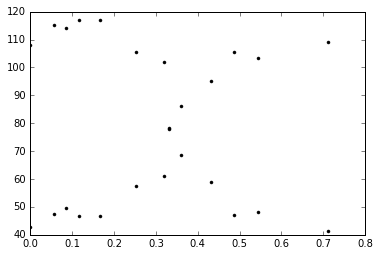

In [127]:
plt.plot(phases(maxima[0], 0, JDp), RVp, 'k.')
plt.plot(phases(maxima[0], 0, JDs), RVs, 'k.')

In [126]:
#Code for finding local maxima

power = y*y2#*y3*y4
#print(x[np.argmax(y*y2*y3*y4)])
#print(np.where((P)>0.025))
maxima = np.array([])
for i in range(1, len(power)-2):
    if power[i-1] < power[i] and power[i] > power[i+1] and power[i] > 0.7:
        maxima = np.append(maxima, x[i])
print(maxima)

[ 2.63100518]


In [120]:
#This periodogram code was taken from
#Jake Vanderplas' "Fast Lomb-Scargle Periodograms in Python"
#modified by myself into a function

def periodogram(t, rv, f):
    
    t = np.array(t)
    rv = np.array(rv)
    
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, 7.5, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, rv - rv.mean(), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / (N * rv.std() ** 2)
    
    return periods, powers

def data_window(t, f): 
#slighty altered periodogram function, computes data window for a set of visits    
    t = np.array(t)
    
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, 7.5, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, np.ones(len(t)), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / N
    
    return periods, powers

#this function removes nan cells from the bad RV visits, and deletes the accompanying JDs 
#from a copy tied to the specific rv list

def adjustment(t, rv):
    adjusted_t = np.asarray(t)
    for i in range(0, len(t)-1):
        if i == len(rv):
            break
        if np.isnan(rv[i]):
            rv         = np.delete(rv, i)
            adjusted_t = np.delete(adjusted_t, i)
    return adjusted_t, rv

def phases(P, T, times): #function converts measurements in time into measurements in orbital phase (from 0-1)
    phased_Times = np.zeros(len(times)) #function is only useful after T and P have been determined
    for i in range(0, len(times)-1):
        phased_Times[i] = ((times[i])-T)/P-int(((times[i])-T)/P)
        if phased_Times[i] < 0:
            phased_Times[i] = phased_Times[i]+1
    return phased_Times

To do here: check goodness of period determination.

-prewhitening
-stacking of the two curves